In [1]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dataloader import GetDocumentObj, DictObj, GetTensor

In [2]:
USE_CUDA = torch.cuda.is_available()
GPU_ID = 1

USE_CUDA

True

In [3]:
top_path = "top_B.parse"
u20_path = "u20_B.parse"

In [4]:
label_dict = {top_path:0, u20_path:1}
list_document = []; start_date = None ; end_date = None
list_document, start_date, end_date = GetDocumentObj(list_document, top_path, label_dict[top_path], start_date, end_date)
list_document, start_date, end_date = GetDocumentObj(list_document, u20_path, label_dict[u20_path], start_date, end_date)

documents_obj = DictObj()
documents_obj.SetDict(list_document)    
time_tensor, loc_tensor, person_organ_tensor, morph_tensor, list_label = GetTensor(list_document, documents_obj, start_date, end_date)

print(time_tensor, loc_tensor, person_organ_tensor, morph_tensor, len(list_label))


 0.0000  0.0000  0.0000  ...   0.0261  0.0198  0.0149
 0.0000  0.0000  0.0000  ...   0.0261  0.0198  0.0149
 0.0000  0.0000  0.0000  ...   0.0261  0.0198  0.0149
          ...             ⋱             ...          
 0.0000  0.0000  0.0000  ...   0.9560  0.9231  0.8825
 0.0000  0.0000  0.0000  ...   1.0000  0.9950  0.9802
 0.0000  0.0000  0.0000  ...   1.0000  0.9950  0.9802
[torch.FloatTensor of size 2274x180]
 
    1     1     1  ...      0     0     0
    0     1     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     1     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.IntTensor of size 2274x577]
 
    5     1     1  ...      0     0     0
    5     1     1  ...      0     0     0
    0     0     1  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0

In [5]:
print('시간 뷰 : ', time_tensor.size())
print('장소 뷰 : ', loc_tensor.size())
print('사람기관 뷰 : ', person_organ_tensor.size())
print('나머지 뷰 : ', morph_tensor.size())

시간 뷰 :  torch.Size([2274, 180])
장소 뷰 :  torch.Size([2274, 577])
사람기관 뷰 :  torch.Size([2274, 4092])
나머지 뷰 :  torch.Size([2274, 10802])


In [6]:
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, int(input_size/2)), nn.ReLU(True),
            nn.Linear(int(input_size/2), int(input_size/4)))
        self.decoder = nn.Sequential(
            nn.Linear(int(input_size/4), int(input_size/2)), nn.ReLU(True),
            nn.Linear(int(input_size/2), input_size), nn.ReLU())  # ReLU, Tanh

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
TOTAL_DATA_NUM = len(time_tensor)
TRAIN_DATA_NUM = int(TOTAL_DATA_NUM*0.8)

In [8]:
def getBatch(data, batch_size=128, isTrain=True):
    if isTrain:
        startIdx = 0
        endIdx = TRAIN_DATA_NUM
    else:
        startIdx = TRAIN_DATA_NUM
        endIdx = len(data)
        
    for idx in range(startIdx, endIdx, batch_size):
        batch = data[idx:min(idx + batch_size, endIdx)]
        yield batch

In [9]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [10]:
def trainModel(model, inputs):
    BATCH_SIZE = 256
    NUM_EPOCH = 200
    
    LR = 1e-3
    WEIGHT_DECAY = 1e-5
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_every = NUM_EPOCH / 10
    plot_every = NUM_EPOCH / 20
    
    for epoch in tqdm(range(1, NUM_EPOCH+1)):
        for batch in getBatch(inputs, batch_size=BATCH_SIZE):
            batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
            # ===================forward=====================
            output = model(batch)
            loss = criterion(output, batch)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print_loss_total += loss.data[0]
            plot_loss_total += loss.data[0]
            
        # ===================log========================
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('epoch [{}/{}], loss:{:.5f}'.format(epoch, NUM_EPOCH, loss.data[0]))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)
    #torch.save(model.state_dict(), './sim_autoencoder.pth')

In [11]:
def evalModel(model, inputs):
    BATCH_SIZE = 256
    
    criterion = nn.MSELoss()
    
    loss = 0
    result = []
    for batch in getBatch(inputs, batch_size=BATCH_SIZE, isTrain=False):
        batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
        
        output = model(batch)
        result.append(output)
        loss += criterion(output, batch)[0]
        
    return loss, result

In [13]:
# 시간뷰 (30 dim)
inputs = time_tensor
INPUT_SIZE = inputs.size()[1]

print(INPUT_SIZE)
model_time = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_time, inputs)


  0%|          | 1/200 [00:00<00:36,  5.48it/s]

180



 10%|█         | 20/200 [00:03<00:34,  5.20it/s]

epoch [20/200], loss:0.00266



 10%|█         | 21/200 [00:04<00:34,  5.18it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/opt/conda/envs/pytorch-py35/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/pytorch-py35/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

 15%|█▌        | 30/200 [00:05<00:31,  5.44it/s]


KeyboardInterrupt: 

In [14]:
# 장소뷰 (308 dim)
inputs = loc_tensor
INPUT_SIZE = inputs.size()[1]

model_loc = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_loc, inputs)

 10%|█         | 20/200 [00:08<01:20,  2.22it/s]

epoch [20/200], loss:0.00165


 20%|██        | 40/200 [00:17<01:10,  2.28it/s]

epoch [40/200], loss:0.00139


 25%|██▌       | 50/200 [00:21<01:04,  2.32it/s]

KeyboardInterrupt: 

 10%|█         | 20/200 [01:17<11:33,  3.85s/it]

epoch [20/200], loss:0.03126


 20%|██        | 40/200 [02:33<10:15,  3.85s/it]

epoch [40/200], loss:0.02863


 30%|███       | 60/200 [03:50<08:58,  3.85s/it]

epoch [60/200], loss:0.02650


 40%|████      | 80/200 [05:08<07:42,  3.85s/it]

epoch [80/200], loss:0.02521


 50%|█████     | 100/200 [06:22<06:22,  3.83s/it]

epoch [100/200], loss:0.02429


 60%|██████    | 120/200 [07:35<05:03,  3.80s/it]

epoch [120/200], loss:0.02395


 70%|███████   | 140/200 [08:48<03:46,  3.77s/it]

epoch [140/200], loss:0.02379


 80%|████████  | 160/200 [10:00<02:30,  3.76s/it]

epoch [160/200], loss:0.02264


 90%|█████████ | 180/200 [11:20<01:15,  3.78s/it]

epoch [180/200], loss:0.02262


100%|██████████| 200/200 [12:36<00:00,  3.78s/it]

epoch [200/200], loss:0.02200


<Figure size 432x288 with 0 Axes>

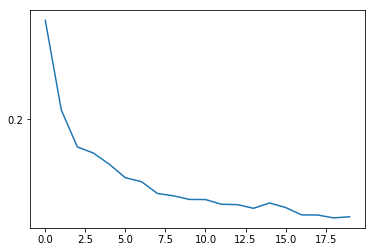

In [13]:
# 나머지뷰 (7687 dim)
inputs = morph_tensor
INPUT_SIZE = inputs.size()[1]

model_morph = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_morph, inputs)

 10%|█         | 20/200 [00:23<03:34,  1.19s/it]

epoch [20/200], loss:0.00534


 20%|██        | 40/200 [00:47<03:11,  1.20s/it]

epoch [40/200], loss:0.00471


 30%|███       | 60/200 [01:11<02:46,  1.19s/it]

epoch [60/200], loss:0.00437


 40%|████      | 80/200 [01:35<02:22,  1.19s/it]

epoch [80/200], loss:0.00431


 50%|█████     | 100/200 [01:58<01:58,  1.18s/it]

epoch [100/200], loss:0.00424


 60%|██████    | 120/200 [02:22<01:34,  1.19s/it]

epoch [120/200], loss:0.00424


 70%|███████   | 140/200 [02:46<01:11,  1.19s/it]

epoch [140/200], loss:0.00404


 80%|████████  | 160/200 [03:10<00:47,  1.19s/it]

epoch [160/200], loss:0.00406


 90%|█████████ | 180/200 [03:34<00:23,  1.19s/it]

epoch [180/200], loss:0.00413


100%|██████████| 200/200 [03:58<00:00,  1.19s/it]

epoch [200/200], loss:0.00430


<Figure size 432x288 with 0 Axes>

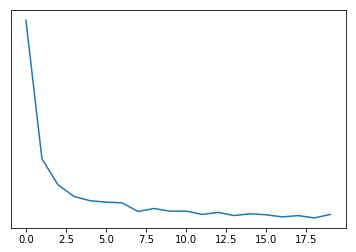

In [14]:
# 사람기관뷰 (2344 dim)
inputs = person_organ_tensor
INPUT_SIZE = inputs.size()[1]

model_person_organ = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModel(model_person_organ, inputs)

In [82]:
results = []

results.append(evalModel(model_time, time_tensor))
results.append(evalModel(model_loc, loc_tensor))
results.append(evalModel(model_morph, morph_tensor))
results.append(evalModel(model_person_organ, person_organ_tensor))

[result[0].data.tolist()[0]/TOTAL_DATA_NUM for result in results]
# 시간 뷰만 Float타입이니까 어렵, 사이즈 큰 건 sparse해서 학습하기 쉬움?

[0.0003474430354462424,
 5.5849036628371214e-06,
 4.446591602976933e-05,
 1.3051042103099665e-05]

In [31]:
# 직접 결과 보기 (시간뷰)
test_input = next(getBatch(time_tensor, batch_size=1, isTrain=False))
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)

In [56]:
test_output = model_time(test_input)

In [96]:
with open("time_MSE.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [100]:
# 직접 결과 보기 (사람기관 뷰)
test_input = next(getBatch(person_organ_tensor, batch_size=1, isTrain=True))
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)

In [101]:
test_output = model_person_organ(test_input)

In [103]:
with open("person_organ_MSE.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [104]:
# 직접 결과 보기 (나머지 뷰)
test_input = next(getBatch(morph_tensor, batch_size=1, isTrain=True))
test_input = Variable(torch.FloatTensor(test_input.tolist())).cuda(GPU_ID)

In [105]:
test_output = model_morph(test_input)

In [106]:
with open("morph_MSE.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [72]:
test_output = model_loc(test_input)

In [97]:
with open("loc_MSE.txt", "w") as f:
    compared_list = list(zip(np.round(test_input.data.tolist(), decimals=4).tolist()[0], np.round(test_output.data.tolist(), decimals=4).tolist()[0]))
    
    f.write('tgt gen\n')
    for compared in compared_list:
        f.write('{} {}\n'.format(compared[0], compared[1]))

In [109]:
#loss function : KLD
def trainModelKLD(model, inputs):
    BATCH_SIZE = 256
    NUM_EPOCH = 200
    
    LR = 1e-3
    WEIGHT_DECAY = 1e-5
    
    criterion = nn.KLDivLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    print_every = NUM_EPOCH / 10
    plot_every = NUM_EPOCH / 20
    
    for epoch in tqdm(range(1, NUM_EPOCH+1)):
        for batch in getBatch(inputs, batch_size=BATCH_SIZE):
            batch = Variable(torch.FloatTensor(batch.tolist())).cuda(GPU_ID)
            # ===================forward=====================
            output = model(batch)
            loss = criterion(output, batch)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print_loss_total += loss.data[0]
            plot_loss_total += loss.data[0]
            
        # ===================log========================
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('epoch [{}/{}], loss:{:.5f}'.format(epoch, NUM_EPOCH, loss.data[0]))
        
        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)
    #torch.save(model.state_dict(), './sim_autoencoder.pth')

In [110]:
# 시간뷰 (30 dim)
inputs = time_tensor
INPUT_SIZE = inputs.size()[1]

model_time_KLD = SimpleAutoencoder(INPUT_SIZE).cuda(GPU_ID)
trainModelKLD(model_time, inputs)

 12%|█▏        | 23/200 [00:01<00:14, 12.30it/s]

epoch [20/200], loss:-32.66695


 22%|██▏       | 43/200 [00:03<00:11, 13.69it/s]

epoch [40/200], loss:-767.20831


 32%|███▏      | 63/200 [00:04<00:09, 14.04it/s]

epoch [60/200], loss:-4931.36816


 42%|████▏     | 83/200 [00:05<00:08, 14.46it/s]

epoch [80/200], loss:-17456.33398


 52%|█████▏    | 103/200 [00:06<00:06, 14.81it/s]

epoch [100/200], loss:-44931.16406


 62%|██████▏   | 123/200 [00:08<00:05, 14.95it/s]

epoch [120/200], loss:-95136.36719


 72%|███████▏  | 143/200 [00:09<00:03, 15.11it/s]

epoch [140/200], loss:-176691.23438


 82%|████████▏ | 163/200 [00:10<00:02, 15.23it/s]

epoch [160/200], loss:-298786.81250


 92%|█████████▏| 183/200 [00:11<00:01, 15.31it/s]

epoch [180/200], loss:-470985.12500


100%|██████████| 200/200 [00:13<00:00, 15.31it/s]


epoch [200/200], loss:-706022.93750
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f584b1ec048> (for post_execute):


RuntimeError: Locator attempting to generate 16658302 ticks from -3180228.6000000006 to 151431.59999999963: exceeds Locator.MAXTICKS

<Figure size 432x288 with 0 Axes>

RuntimeError: Locator attempting to generate 16658302 ticks from -3180228.6000000006 to 151431.59999999963: exceeds Locator.MAXTICKS

<Figure size 432x288 with 1 Axes>